<a href="https://colab.research.google.com/github/thedenaas/jub_ml/blob/main/fall_2022/lecture_4/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from enum import Enum

from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_circles, load_iris
from sklearn.metrics import pairwise_distances
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from collections import defaultdict
import sys

In [56]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

Generate data fot the tasks

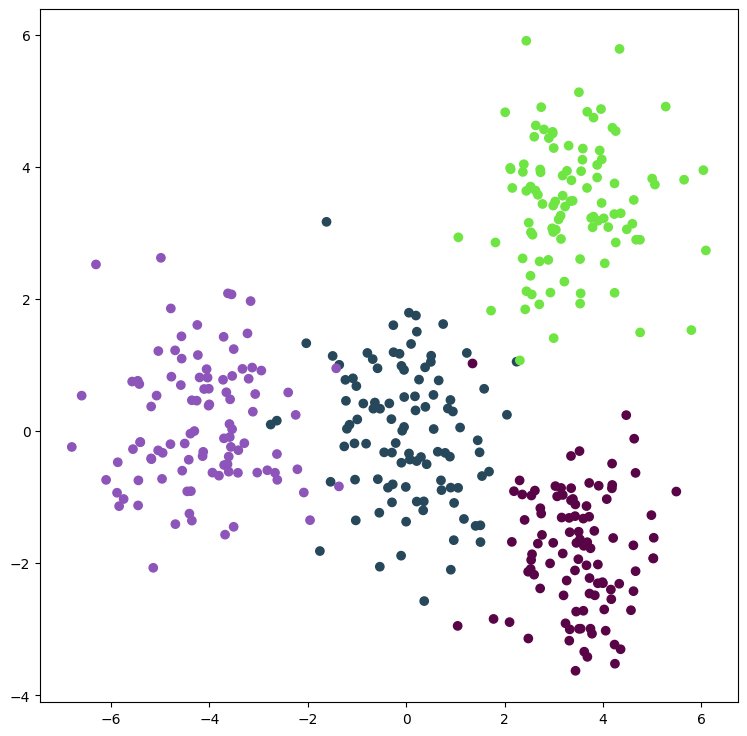

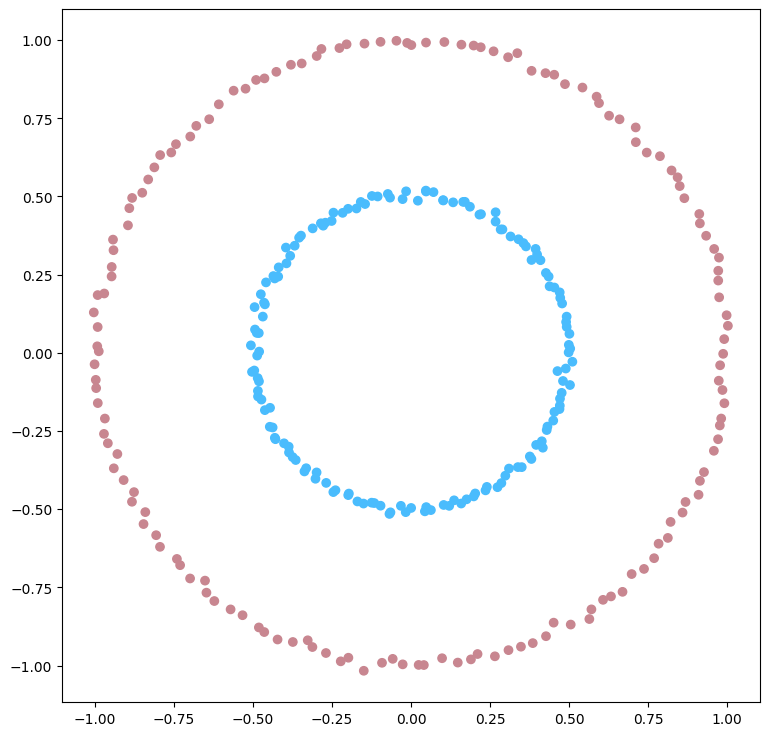

In [57]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_circles(n_samples=300, noise=0.01, factor=0.5)
visualize_clasters(X_2, true_labels)

X_iris = load_iris().data

### **Task 1. k-Means [20 pts]**
Implement k-means

#### initialization
* n_clusters - number of clusters
* init - how centers of the clusters are selected
    1. `random` - clusters' centroids are chosen at random
    2. `sample` - clusters' centroids are chosen at random from the given data

#### functionality
* `fit(X, y=None)` - initialize `self.centroids`, perform search for the best `self.centroids` values of clusters on the given data X (y is ignored)
* `predict(X)` - for each point in `X` returns number of the predicted cluster



__Don't forget to re-initialize empty cluster during the training for better convergence!__

In [58]:
class CentroidsChoosingMethod(Enum):
    Random = 0
    Sample = 1


def get_nearest_centroid_index(centroids, x):
    result_index = 0
    for i in range(len(centroids)):
        centroid = centroids[i]
        if np.linalg.norm(x - centroid) < np.linalg.norm(x - centroids[result_index]):
            result_index = i
    return result_index


def choose_new_centroid(method, X):
    if method == CentroidsChoosingMethod.Random:
        return np.random.random_sample((X.shape[1]))
    else:
        return X[np.random.randint(0, X.shape[0]), :]


class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        self.centroids_choosing = CentroidsChoosingMethod.Random if (
                init == "random") else CentroidsChoosingMethod.Sample
        self.centroids = []
        self.eps = 0.001

    def fit(self, X, y=None):
        self.centroids = [choose_new_centroid(self.centroids_choosing, X) for _ in range(self.k)]

        for _ in range(self.max_iter):
            h = self.predict(X)

            some_centroid_changed = False
            for i in range(self.k):
                cluster_points = []
                for (point, centroid_index) in zip(X, h):
                    if centroid_index == i:
                        cluster_points.append(point)
                if len(cluster_points) == 0:
                    new_centroid = choose_new_centroid(self.centroids_choosing, X)
                else:
                    new_centroid = sum(cluster_points) / len(cluster_points)
                if np.linalg.norm(self.centroids[i] - new_centroid) > self.eps:
                    some_centroid_changed = True
                self.centroids[i] = sum(cluster_points) / len(cluster_points)
            if not some_centroid_changed:
                break

    def predict(self, X):
        return [get_nearest_centroid_index(self.centroids, x) for x in X]

Test on the synthetic data.

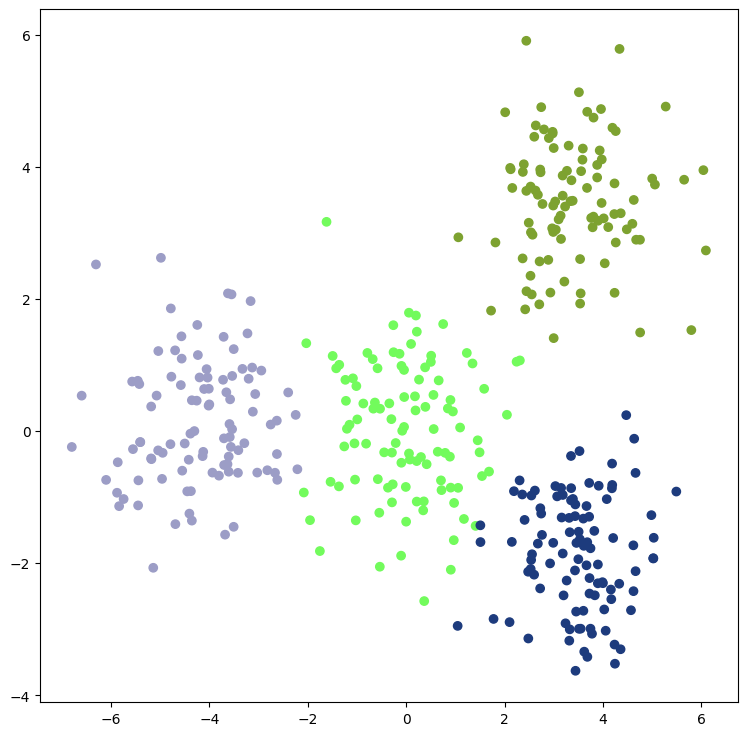

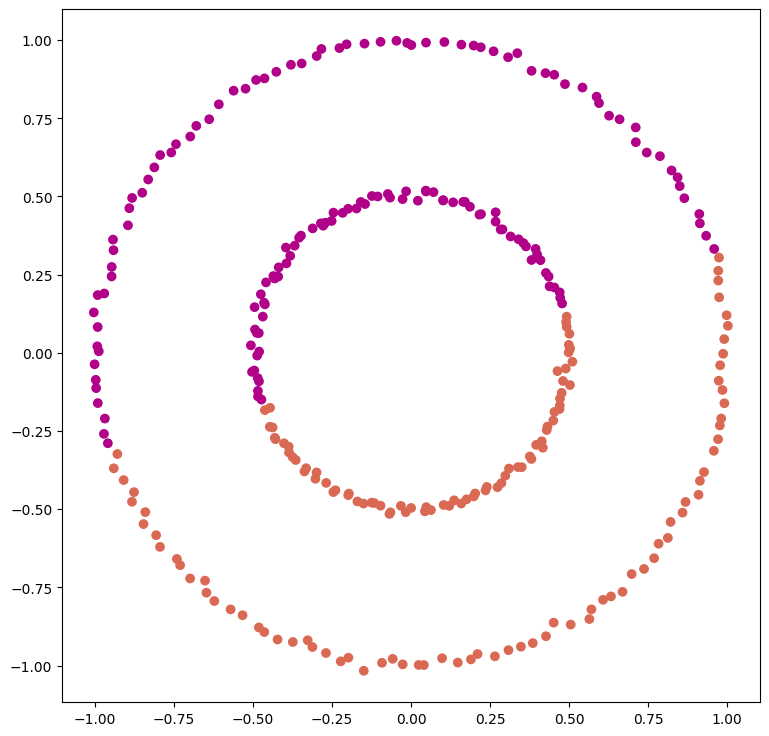

In [59]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### **Task 2. k-Means++ [20 pts]**
Implement k-means++.


The only difference from k-Means is how clusters are initialized. Here centroids are chosen from the given data one by one. Each new centroid is chosen with the probability proportional to the squared distance to the closest exsitent centroid.


#### initialization
* n_clusters - number of clusters.

    
#### functionality
* `fit(X, y=None)` - initialize `self.centroids`, perform search for the best `self.centroids` values of clusters on the given data X (y is ignored)
* `predict(X)` - for each point in `X` returns number of the predicted cluster



__Don't forget to re-initialize empty cluster during the training for better convergence!__

In [60]:
class KMeans_pp:
    def __init__(self, n_clusters, max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        self.centroids = []
        self.eps = 0.001

    def fit(self, X, y=None):
        self.centroids = [X[np.random.randint(0, len(X))]]

        max_distance_from_centroids = [np.linalg.norm(self.centroids[0] - x) for x in X]

        for _ in range(self.k - 1):
            normalization_coef = np.linalg.norm(max_distance_from_centroids, ord=1)
            new_centroid = X[
                np.random.choice(range(len(X)), p=[dist / normalization_coef for dist in max_distance_from_centroids])]

            for i in range(len(max_distance_from_centroids)):
                max_distance_from_centroids[i] = min(max_distance_from_centroids[i],
                                                     np.linalg.norm(X[i] - new_centroid))

            self.centroids.append(new_centroid)

        for _ in range(self.max_iter):
            h = self.predict(X)

            some_centroid_changed = False
            for i in range(self.k):
                cluster_points = []
                for (point, centroid_index) in zip(X, h):
                    if centroid_index == i:
                        cluster_points.append(point)
                if len(cluster_points) == 0:
                    new_centroid = choose_new_centroid(CentroidsChoosingMethod.Sample, X)
                else:
                    new_centroid = sum(cluster_points) / len(cluster_points)
                if np.linalg.norm(self.centroids[i] - new_centroid) > self.eps:
                    some_centroid_changed = True
                self.centroids[i] = sum(cluster_points) / len(cluster_points)
            if not some_centroid_changed:
                break

    def predict(self, X):
        return [get_nearest_centroid_index(self.centroids, x) for x in X]

Test on the synthetic data.

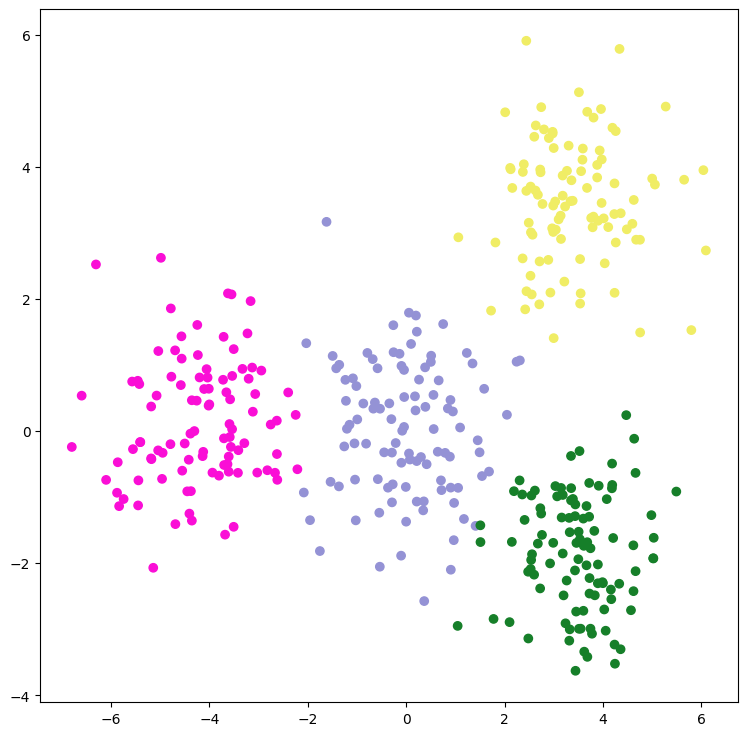

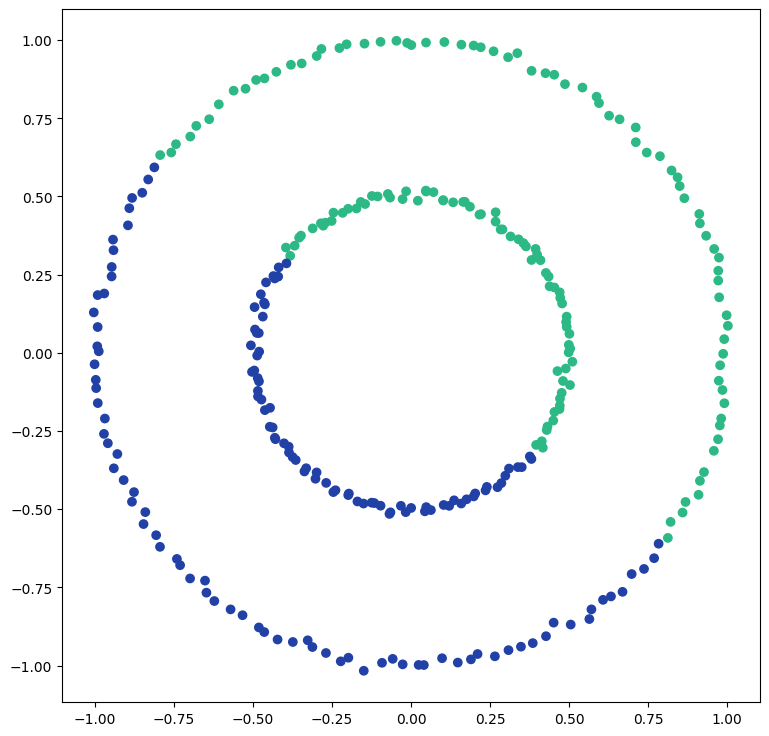

In [61]:
kmeans = KMeans_pp(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans_pp(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### **Task 3. Elbow [15 pts]**

For this task we will switch from synthetic data and work with [iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. The goal of this task is to idetify how many types of irises there. For this, use an [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Use any variation of the k-means method (even from sklearn). You can use any clusterization metric but we advise to use sum of the squared distances from points to their centroids (model.interia for the sklearn method). **You need to tell how many classses (or clusters) are in iris dataset**

In [62]:
from sklearn.cluster import KMeans as sklearn_KMeans
from sklearn.datasets import load_iris

[[1, -681.3706], [2, -152.34795176035792], [3, -78.85144142614601], [4, -57.22847321428571], [5, -46.44618205128205], [6, -39.066035353535355], [7, -34.57303082786778], [8, -29.99042640692641], [9, -28.359539188881293]]


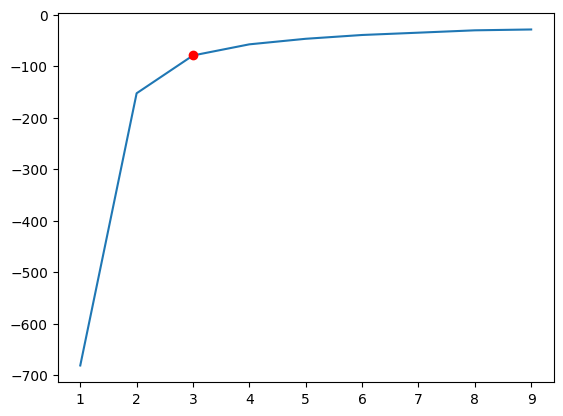

In [63]:
# X_iris
X_iris = load_iris()['data']
result = []
for clusters in range(1, 10):
    clusterization = sklearn_KMeans(n_clusters=clusters).fit(X_iris)
    result.append([clusters, clusterization.score(X_iris)])
print(result)
result = np.array(result)
plt.figure()
plt.plot(result[:, 0], result[:, 1])
plt.plot(result[2][0], result[2][1], 'ro')
plt.show()


As we can see from elbow method the best number of clusters is 3


### **Task 4. DBSCAN [15 pts]**

Implement DBSCAN.

DBSCAN finds core samples of high density and expands clusters from them. For this DBSCAN initialy builds a graph, where datapoints are verticies and edges connect two points if the distance between them is less than therhold **eps**. Each datapoint with at least **min_samples** points in the neighborhood is considered a core point. Each connectivity component with at least one core point is considered a cluster (and all points within are in the same clusters.) Verticies in a compenent w/out core points are clusterless.

#### initialization
* eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other
* min_samples - The number of samples in a neighborhood for a point to be considered as a core point.


#### methods
`fit_predict(X, y=None)` - trains model on `X` and returns predicted classes for the `X` (y is ignored). Use KDTree for fast search of the close points (method *query_radius*).

In [64]:
class DSU(object):
    def __init__(self, n):
        self.parents = [i for i in range(n)]

    def find(self, x):
        if self.parents[x] != x:
            self.parents[x] = self.find(self.parents[x])
        return self.parents[x]

    def union(self, x, y):
        rootA, rootB = self.find(x), self.find(y)
        if rootA != rootB:
            self.parents[rootA] = rootB


class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size

    def check_points_for_adjacency(self, point1, point2):
        return np.linalg.norm(point1 - point2) <= self.eps

    def fit_predict(self, X, y=None):
        dsu = DSU(X.shape[0])

        adjacency_matrix = [[self.check_points_for_adjacency(first, second) for second in X] for first in X]

        core_points_mask = [mask.count(True) >= self.min_samples for mask in adjacency_matrix]

        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                if core_points_mask[i] and core_points_mask[j] and adjacency_matrix[i][j]:
                    dsu.union(i, j)
        prediction = []
        mapping = {}
        next_cluster_index = 0

        for i in range(X.shape[0]):
            if core_points_mask[i]:
                color = dsu.find(i)
                if color not in mapping:
                    mapping[color] = next_cluster_index
                    next_cluster_index += 1
                prediction.append(mapping[color])
                continue
            adj_to_cores = [core_points_mask[j] and adjacency_matrix[i][j] for j in range(X.shape[0])]
            if not any(adj_to_cores):
                prediction.append(-1)
                continue
            color = dsu.find(adj_to_cores.index(True))
            if color not in mapping:
                mapping[color] = next_cluster_index
                next_cluster_index += 1
            prediction.append(mapping[color])
        return prediction





In [65]:
def visualize_clasters_for_dbscan(X, labels):
    clustered_labels = list(filter(lambda x: x >= 0, labels))
    unique_labels = np.unique(clustered_labels)
    print(f"Amount of clusters marked = {len(unique_labels)}")
    unique_colors = np.random.random((len(unique_labels) + 1, 3))
    unique_colors[-1] = np.array([0, 0, 0])
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

Test on synthetic data. If necessery find best number of clusters


Amount of clusters marked = 4


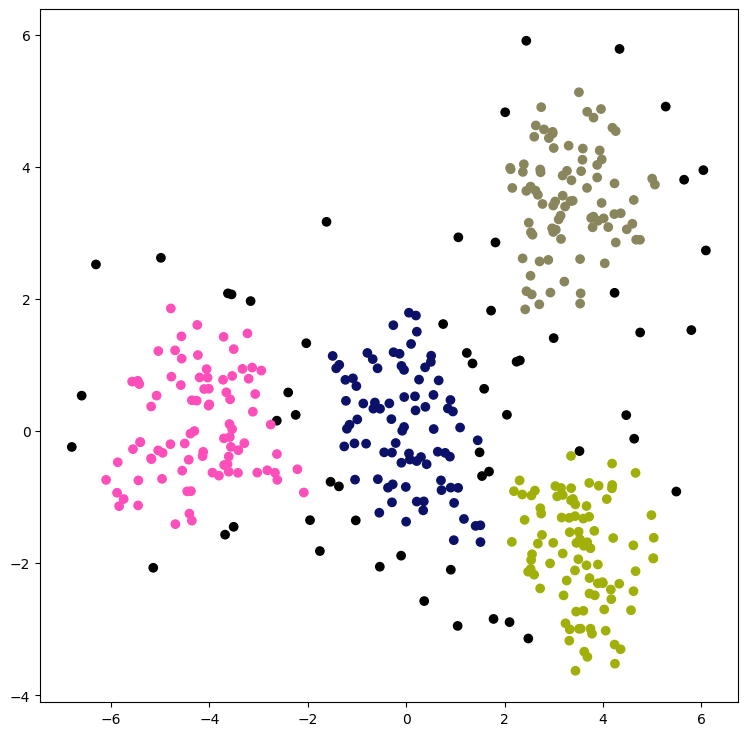

Amount of clusters marked = 1


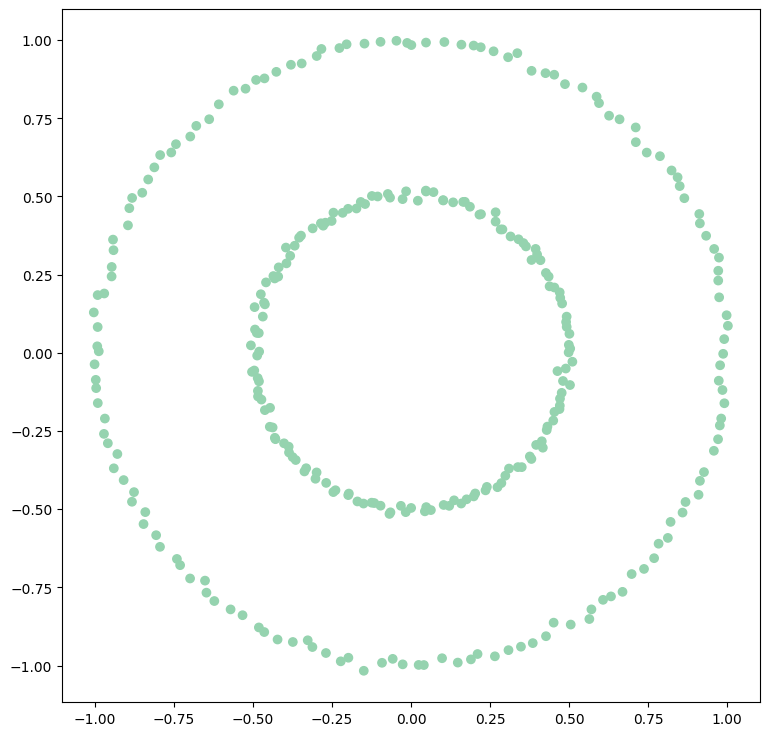

In [66]:
agg_clustering = DBScan()
labels = agg_clustering.fit_predict(X_1)
visualize_clasters_for_dbscan(X_1, labels)

agg_clustering = DBScan()
labels = agg_clustering.fit_predict(X_2)
visualize_clasters_for_dbscan(X_2, labels)

### **Task 5. Feature engineering [15 pts]**

Which model k-Means or DBSCAN is better on the circles data? Why? Is it possible to improve weaker model with the feature engineering? (If yes - show that.)

Amount of clusters marked = 2


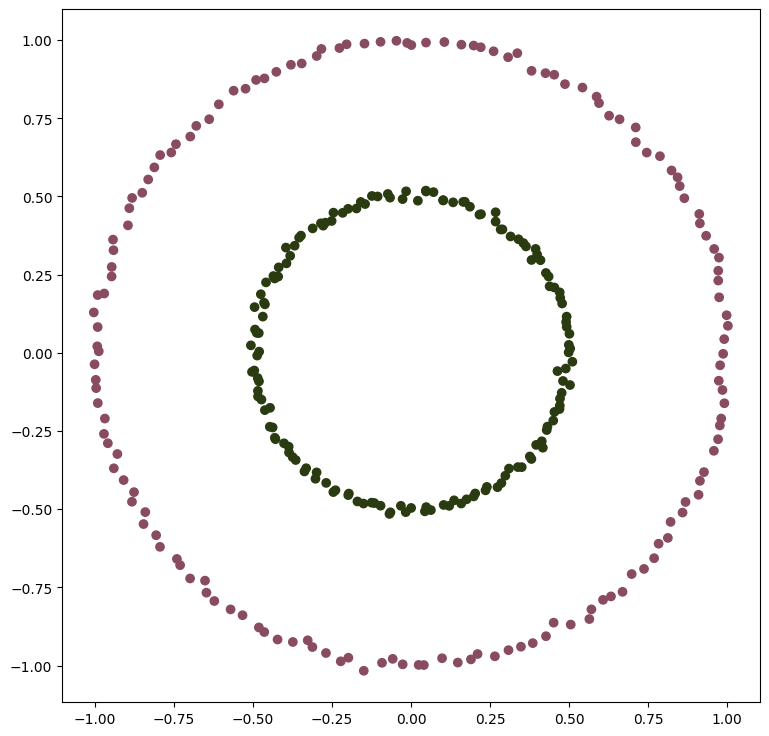

In [67]:
# Both algorithms on standard features are bad on circles data.
# K means is bad because even if it gets the perfect clusterization the next step will break it all. That's because the centroids will be right in the center and all points at the next iteration will be in two parts.
# DBSCAN clustering with such a big epsilon won't do any better because all the points from both circles will be marked as core points and if eps is ~0.5 then they will go to the same cluster.

# I will assume that DBSCAN is the weak model because it didn't perform any clusterization.
# However, it can be fixed with feature engineering. We can decrease epsilon:

agg_clustering = DBScan(eps=0.25)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters_for_dbscan(X_2, labels)

### **Task 4. Agglomerative clustering [20 pts]**

Implement Agglomerative Clustering.

Agglomerative Clustering is a bottom-up clustering approach. It is initialized with each point in its own cluster. After that iteratively two closest clusters are merged. The procedure ends when the specified numbers of clusters are met.

#### initialization
* n_clusters - number of clusters.


#### methods
`fit_predict(X, y=None)` - trains model on `X` and returns predicted classes for the `X` (y is ignored). Calculate distance between classes as an minimal pairwise distance between points from both clusters (*$min_{p\in C_1, q \in C_2 |p_1-p_2|}$*)



In [68]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.k = n_clusters
        if linkage == "average":
            self.dist_function = self.dist_average
        elif linkage == "complete":
            self.dist_function = self.dist_complete
        else:
            self.dist_function = self.dist_single

    @staticmethod
    def dist_average(ind1, ind2, X):
        return np.mean(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    @staticmethod
    def dist_single(ind1, ind2, X):
        return np.min(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    @staticmethod
    def dist_complete(ind1, ind2, X):
        return np.max(np.apply_along_axis(lambda v: np.linalg.norm(v - X[ind1], axis=1), 1, X[ind2]))

    def fit_predict(self, X, y=None):
        clusters = {i: [i] for i in range(X.shape[0])}
        dist_matrix = {}
        for i in clusters:
            for j in clusters:
                if i < j:
                    dist_matrix[i, j] = self.dist_function(clusters[i], clusters[j], X)
        while len(clusters) > self.k:
            cl1, cl2 = min(dist_matrix, key=dist_matrix.get)
            clusters[cl1].extend(clusters[cl2])
            del clusters[cl2]
            for cl3 in clusters:
                del dist_matrix[min(cl3, cl2), max(cl3, cl2)]
                if cl3 != cl1:
                    dist_matrix[min(cl3, cl1), max(cl3, cl1)] = self.dist_function(clusters[cl1], clusters[cl3], X)
        ans = -np.ones(X.shape[0]).astype(int)
        for ind, cl in enumerate(clusters):
            ans[clusters[cl]] = ind
        return ans

Test on sythnetoc data. If necessery find best number of clusters

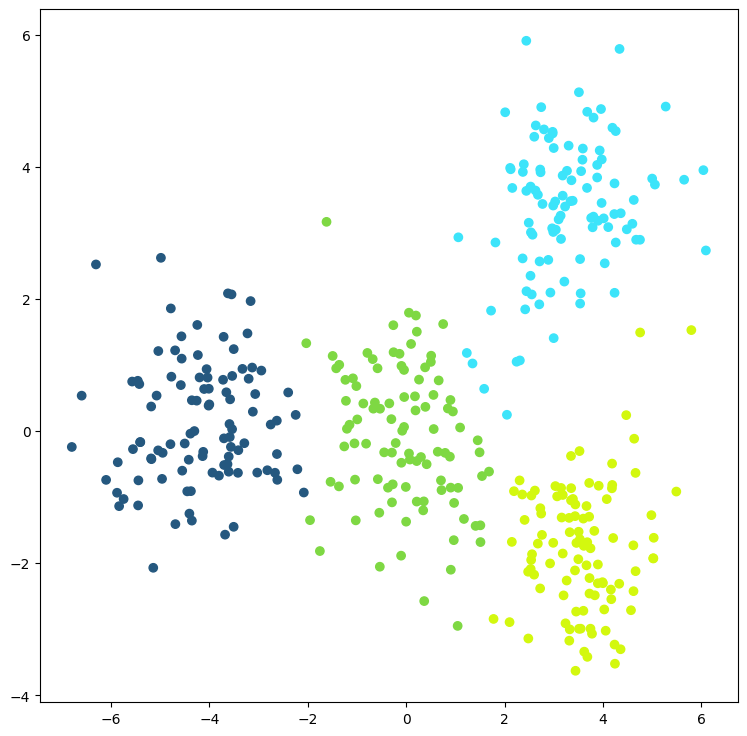

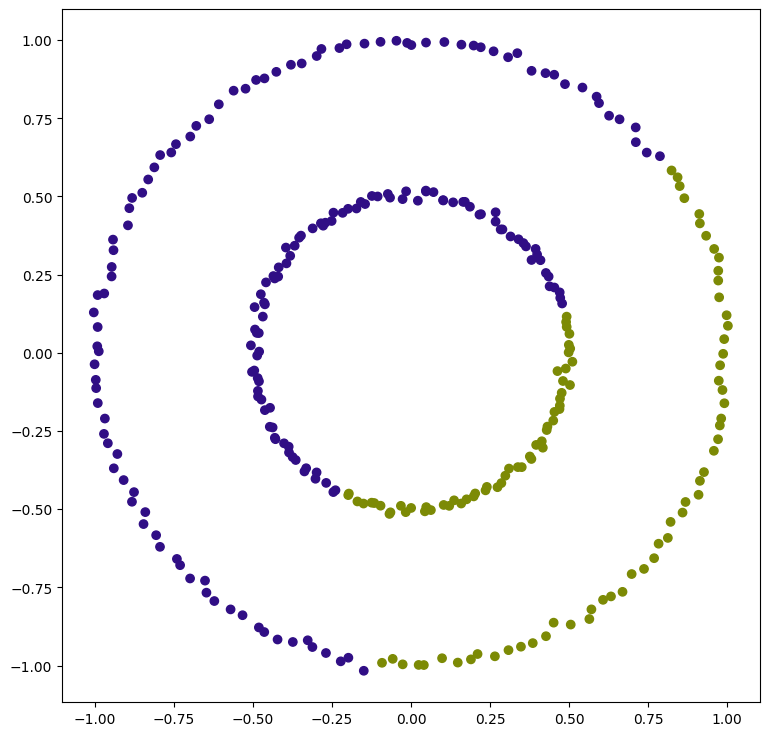

In [69]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### **Task 5. Feature engineering [15 pts]**

Which model k-Means or Agglomerative Clustering is better on the circles data? Why? Is it possible to improve weaker model with the feature engineering? (If yes - show that.)


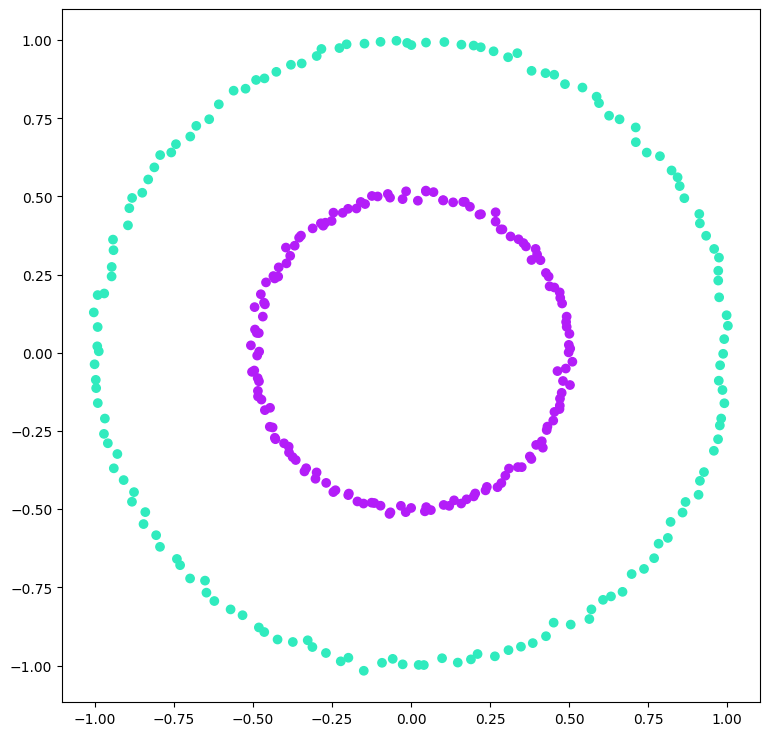

In [70]:
# Both algorithms on standard features are bad on circles data.
# K means is bad because even if it gets the perfect clusterization the next step will break it all. That's because the centroids will be right in the center and all points at the next iteration will be in two parts.
# Agglomerative clustering with mean or max linkage won't do any better because there are situations that can make this algo work wrong. For example if only one half of one circle became one cluster and only one half from the other circle became another cluster then mean between these two clusters will be almost 0.

# However feature linkage can do the trick because it'll go just like Cruscall's algorithm:

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="simple")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### **Task 6. Pixel clustering [15 pts]**

Implemet function that will clusterize colors of the image with k-Means. The function should return an image where each pixel is replace by the color its centroid. 


*The image is a matrix with [h, w, 3], where h, w is dimentions of the image. A pixel is a vector with 3 values.*



In [71]:
# functions for reading, showing, and saving images
def read_image(path):
    im = cv2.imread(path)
    return im[:, :, ::-1]


def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def save_image(image, path):
    cv2.imwrite(path, image[:, :, ::-1])

In [72]:
def clusterize_image(image, col=8):
    # you can change signature of the function as you want
    pixels = image.reshape(-1, 3)

    kmeans = sklearn_KMeans(n_clusters=col)
    labels = kmeans.fit_predict(pixels)
    centroids = kmeans.cluster_centers_
    recolored = np.array([centroids[centroid_index] / 255.0 for centroid_index in labels]).reshape(
        (image.shape[0], image.shape[1], 3))

    return recolored

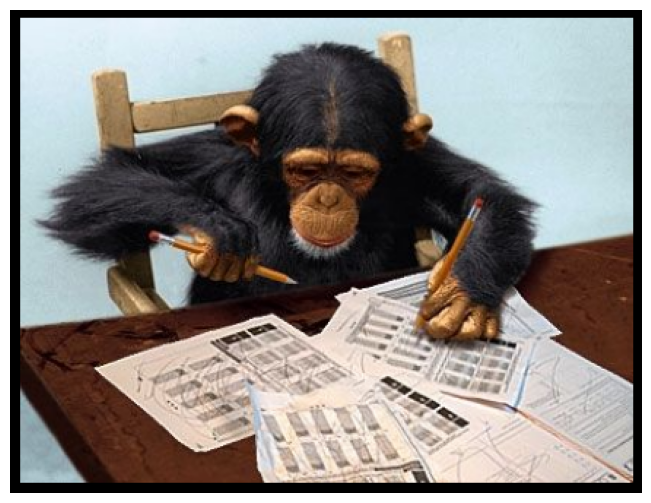

In [73]:
image = read_image("./images/img.png")
show_image(image)

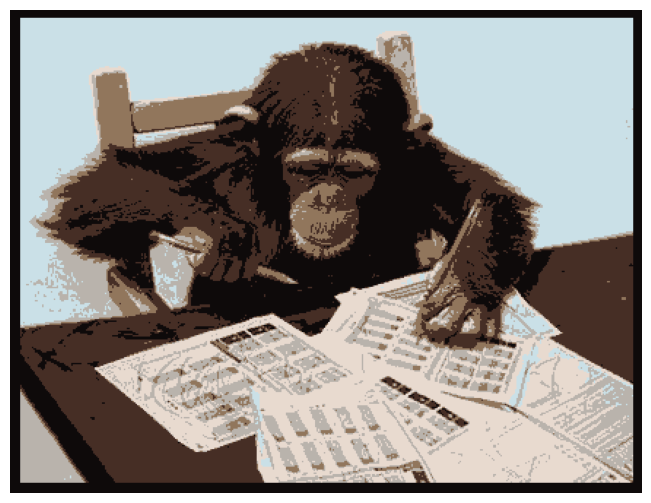

In [74]:
image = read_image("./images/img.png")
result = clusterize_image(image, col=6)
show_image(result)